In [39]:
from statsbombpy import sb
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

## Matches Analysis

In [4]:
competitions = sb.competitions()
serie_a = competitions[competitions['competition_name'] == 'Serie A']
serie_a

/opt/miniconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
66,12,27,Italy,Serie A,male,False,False,2015/2016,2024-06-25T23:56:11.910924,None,None,2024-06-25T23:56:11.910924
67,12,86,Italy,Serie A,male,False,False,1986/1987,2023-06-18T01:55:53.343752,None,None,2023-06-18T01:55:53.343752


In [5]:
matches_1516 = sb.matches(competition_id=12, season_id=27)

/opt/miniconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [6]:
matches_napoli = matches_1516[matches_1516['home_team'].str.contains('Napoli') | matches_1516['away_team'].str.contains('Napoli')]
matches_napoli = matches_napoli.sort_values('match_date', ascending=True)
matches_napoli.reset_index(drop=True, inplace=True)
matches_napoli_filtered = matches_napoli.drop(columns=['shot_fidelity_version', 'xy_fidelity_version', 'competition', 'season', 'competition_stage', 'last_updated', 'last_updated_360', 'data_version', 'match_status', 'match_status_360'])

In [7]:
matches_napoli_filtered['home_play'] = matches_napoli_filtered['home_team'] == 'Napoli'
matches_napoli_filtered['result'] = np.where(
    matches_napoli_filtered['home_play'], 
    matches_napoli_filtered['home_score'] - matches_napoli_filtered['away_score'],  # If Napoli played at home
    matches_napoli_filtered['away_score'] - matches_napoli_filtered['home_score']   # If Napoli played away
)
matches_napoli_filtered['result'] = np.where(
    matches_napoli_filtered['result'] > 0,  # Napoli won
    "Win",
    np.where(
        matches_napoli_filtered['result'] == 0,  # Draw
        "Draw",
        "Lose"  # Napoli lost
    )
)
matches_napoli_filtered 

,match_id,match_date,kick_off,home_team,away_team,home_score,away_score,match_week,stadium,referee,home_managers,away_managers,home_play,result
0,3878546,2015-08-23,20:45:00.000,Sassuolo,Napoli,2,1,1,MAPEI Stadium - Città del Tricolore,Daniele Doveri,Eusebio Di Francesco,Maurizio Sarri,False,Lose
1,3878558,2015-08-30,20:45:00.000,Napoli,Sampdoria,2,2,2,Stadio Diego Armando Maradona,Andrea Gervasoni,Maurizio Sarri,Walter Zenga,True,Draw
2,3878597,2015-09-13,15:00:00.000,Empoli,Napoli,2,2,3,Stadio Carlo Castellani,Luca Banti,Marco Giampaolo,Maurizio Sarri,False,Draw
3,3878604,2015-09-20,20:45:00.000,Napoli,Lazio,5,0,4,Stadio Diego Armando Maradona,Antonio Damato,Maurizio Sarri,Stefano Pioli,True,Win
4,3879539,2015-09-23,20:45:00.000,Carpi,Napoli,0,0,5,Stadio Alberto Braglia (Modena),Gianluca Rocchi,Fabrizio Castori,Maurizio Sarri,False,Draw
5,3879548,2015-09-26,20:45:00.000,Napoli,Juventus,2,1,6,Stadio Diego Armando Maradona,Daniele Orsato,Maurizio Sarri,Massimiliano Allegri,True,Win
6,3879562,2015-10-04,20:45:00.000,AC Milan,Napoli,0,4,7,Stadio Giuseppe Meazza,Nicola Rizzoli,Siniša Mihajlović,Maurizio Sarri,False,Win
7,3879572,2015-10-18,15:00:00.000,Napoli,Fiorentina,2,1,8,Stadio Diego Armando Maradona,Luca Banti,Maurizio Sarri,Paulo Manuel Carvalho de Sousa,True,Win
8,3879581,2015-10-25,20:45:00.000,Chievo,Napoli,0,1,9,Stadio Marc''Antonio Bentegodi,Davide Massa,Rolando Maran,Maurizio Sarri,False,Win
9,3879593,2015-10-28,21:45:00.000,Napoli,Palermo,2,0,10,Stadio Diego Armando Maradona,Piero Giacomelli,Maurizio Sarri,Giuseppe Iachini,True,Win


In [8]:
# Count the number of occurrences for each result
matches_napoli_filtered['result'].value_counts()

result
Win     25
Draw     7
Lose     6
Name: count, dtype: int64

In [9]:
home_wins = matches_napoli_filtered[(matches_napoli_filtered['home_play'] == True) & (matches_napoli_filtered['result'] == 'Win')]
print("Home Wins count:",home_wins.__len__())
away_wins = matches_napoli_filtered[(matches_napoli_filtered['home_play'] == False) & (matches_napoli_filtered['result'] == 'Win')]
print("Away Wins count:",away_wins.__len__())
home_losses = matches_napoli_filtered[(matches_napoli_filtered['home_play'] == True) & (matches_napoli_filtered['result'] == 'Lose')]
print("Home Losses count:",home_losses.__len__())
away_losses = matches_napoli_filtered[(matches_napoli_filtered['home_play'] == False) & (matches_napoli_filtered['result'] == 'Lose')]
print("Away Losses count:",away_losses.__len__())
home_draws = matches_napoli_filtered[(matches_napoli_filtered['home_play'] == True) & (matches_napoli_filtered['result'] == 'Draw')]
print("Home Draws count:",home_draws.__len__())
away_draws = matches_napoli_filtered[(matches_napoli_filtered['home_play'] == False) & (matches_napoli_filtered['result'] == 'Draw')]
print("Away Draws count:",away_draws.__len__())

Home Wins count: 16
Away Wins count: 9
Home Losses count: 0
Away Losses count: 6
Home Draws count: 3
Away Draws count: 4


## Events analysis

In [10]:
# Assume matches_napoli_filtered["match_id"].unique() contains the match IDs
match_ids = matches_napoli_filtered["match_id"].unique()

# Initialize an empty list to store the event data for each match
events_napoli = []

# Loop through each match_id and fetch events
for match_id in match_ids:
    events = sb.events(match_id=match_id)  # Fetch events for each match
    events_napoli.append(events)  # Append the events data to the list

# Combine all events into a single DataFrame
events_napoli = pd.concat(events_napoli, ignore_index=True)

# Display the final DataFrame containing events for all Napoli matches

/opt/miniconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-pack

In [11]:
events_napoli['type'].unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Duel', 'Clearance', 'Pressure', 'Interception', 'Miscontrol',
       'Shot', 'Block', 'Goal Keeper', 'Ball Recovery', 'Foul Committed',
       'Foul Won', 'Dribbled Past', 'Dribble', 'Dispossessed', 'Shield',
       '50/50', 'Half End', 'Injury Stoppage', 'Player Off',
       'Substitution', 'Player On', 'Tactical Shift', 'Offside',
       'Referee Ball-Drop', 'Error', 'Bad Behaviour', 'Own Goal For',
       'Own Goal Against'], dtype=object)

In [12]:
index_to_drop = events_napoli[events_napoli['type'].isin(['50/50', 'Half Start', 'Half End', 'Injury Stoppage', 'Player Off', 'Substitution', 'Player On', 'Tactical Shift', 'Referee Ball-Drop', 'Own Goal For', 'Own Goal Against'])].index
events_napoli.drop(index_to_drop, inplace=True)

In [13]:
events_napoli['type'].unique()

array(['Starting XI', 'Pass', 'Ball Receipt*', 'Carry', 'Duel',
       'Clearance', 'Pressure', 'Interception', 'Miscontrol', 'Shot',
       'Block', 'Goal Keeper', 'Ball Recovery', 'Foul Committed',
       'Foul Won', 'Dribbled Past', 'Dribble', 'Dispossessed', 'Shield',
       'Offside', 'Error', 'Bad Behaviour'], dtype=object)

<Axes: title={'center': 'Number of Passes made by Napoli players'}, xlabel='player'>

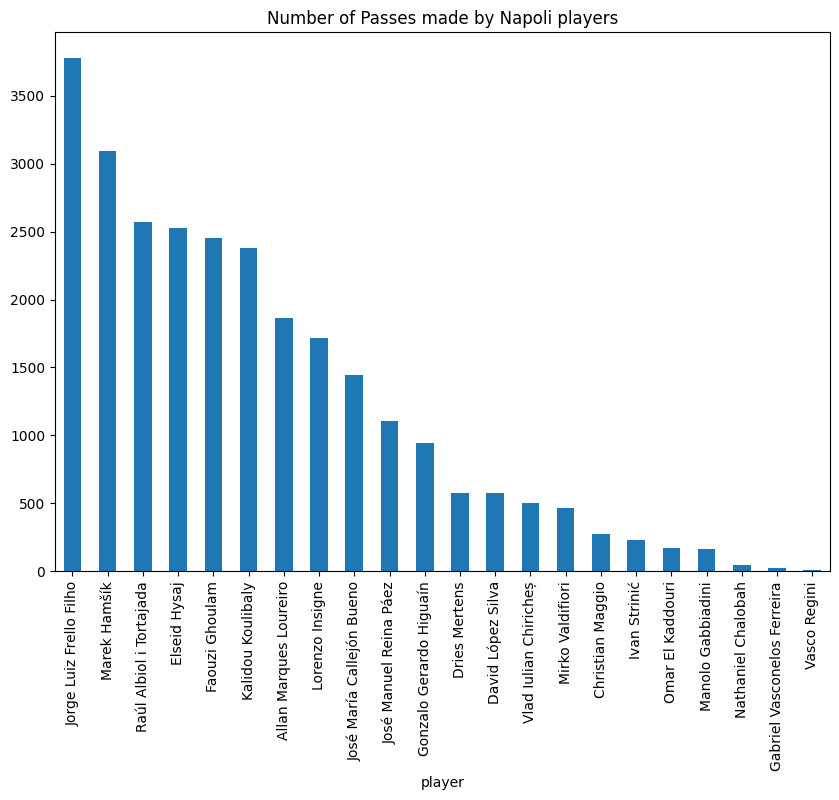

In [14]:
passes = events_napoli[events_napoli['type'] == 'Pass'].dropna(axis=1, how='all')
passes_napoli = passes[passes['team'] == 'Napoli']
plt.figure(figsize=(10, 7))
plt.title('Number of Passes made by Napoli players')
passes_napoli['player'].value_counts().plot(kind='bar')

In [15]:
passes_napoli['pass_goal_assist'].value_counts()

pass_goal_assist
True    55
Name: count, dtype: int64

In [16]:
print("Number of passes leading to a goal or assist:")
passes_napoli[passes_napoli['pass_goal_assist'] == True].groupby('player')['pass_goal_assist'].count().sort_values(ascending=False)

Number of passes leading to a goal or assist:


player
Marek Hamšík                 11
Lorenzo Insigne              10
José María Callejón Bueno     6
Allan Marques Loureiro        5
Dries Mertens                 5
Jorge Luiz Frello Filho       4
Faouzi Ghoulam                3
Manolo Gabbiadini             3
Elseid Hysaj                  2
Gonzalo Gerardo Higuaín       2
Omar El Kaddouri              2
David López Silva             1
Raúl Albiol i Tortajada       1
Name: pass_goal_assist, dtype: int64

In [17]:
print("Number of passes leading to a shot:")
passes_napoli[passes_napoli['pass_shot_assist'] == True].groupby('player')['pass_shot_assist'].count().sort_values(ascending=False)

Number of passes leading to a shot:


player
Marek Hamšík                 81
Jorge Luiz Frello Filho      63
Lorenzo Insigne              58
Gonzalo Gerardo Higuaín      47
José María Callejón Bueno    40
Allan Marques Loureiro       35
Faouzi Ghoulam               28
Dries Mertens                26
Elseid Hysaj                 24
Mirko Valdifiori             12
Manolo Gabbiadini            10
Kalidou Koulibaly             9
Omar El Kaddouri              7
David López Silva             6
Raúl Albiol i Tortajada       4
Christian Maggio              2
Nathaniel Chalobah            2
Ivan Strinić                  1
José Manuel Reina Páez        1
Name: pass_shot_assist, dtype: int64

# Predicting probability of a pass to be an assist

In [ ]:
Find useful features to make the prediction

In [19]:
#deleting not useful features
passes_napoli_filtered = passes_napoli.drop(columns=['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession', 'possession_team', 'play_pattern', 'team', 'duration', 'related_events', 'pass_recipient_id', 'pass_recipient', 'off_camera', 'match_id', 'pass_assisted_shot_id', 'player', 'player_id', 'possession_team_id', 'team_id', 'type', 'pass_outcome'])

# Data Type Format Fix in order to fit Random Forest

LIST OF VALUES

In [20]:
passes_napoli_filtered[['x_start', 'y_start']] = pd.DataFrame(passes_napoli_filtered['location'].apply(lambda loc: eval(loc) if isinstance(loc, str) else loc).tolist(), index=passes_napoli_filtered.index)
passes_napoli_filtered = passes_napoli_filtered.drop('location', axis=1)
passes_napoli_filtered[['x_end', 'y_end']] = pd.DataFrame(passes_napoli_filtered['pass_end_location'].apply(lambda loc: eval(loc) if isinstance(loc, str) else loc).tolist(), index=passes_napoli_filtered.index)
passes_napoli_filtered = passes_napoli_filtered.drop('pass_end_location', axis=1)

STRINGS

In [21]:
# Get unique values in 'pass_body_part' column
unique_body_parts = passes_napoli_filtered['pass_body_part'].unique()

# Create a mapping of unique body parts to float values
mapping = {part: i for i, part in enumerate(unique_body_parts)}

# Replace the original string values with their mapped float values
passes_napoli_filtered['pass_body_part_float'] = passes_napoli_filtered['pass_body_part'].map(mapping)
passes_napoli_filtered = passes_napoli_filtered.drop('pass_body_part', axis=1)
passes_napoli_filtered['pass_body_part_float'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [22]:
# Get unique values in 'pass_type' column
unique_pass_type = passes_napoli_filtered['pass_type'].unique()

# Create a mapping of unique pass type to float values
mapping = {part: i for i, part in enumerate(unique_pass_type)}

# Replace the original string values with their mapped float values
passes_napoli_filtered['pass_type_float'] = passes_napoli_filtered['pass_type'].map(mapping)
passes_napoli_filtered = passes_napoli_filtered.drop('pass_type', axis=1)
passes_napoli_filtered['pass_type_float'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [23]:
# Get unique values in 'pass_height' column
unique_pass_height = passes_napoli_filtered['pass_height'].unique()

# Create a mapping of unique pass height to float values
mapping = {part: i for i, part in enumerate(unique_pass_height)}

# Replace the original string values with their mapped float values
passes_napoli_filtered['pass_height_float'] = passes_napoli_filtered['pass_height'].map(mapping)
passes_napoli_filtered = passes_napoli_filtered.drop('pass_height', axis=1)
passes_napoli_filtered['pass_height_float'].unique()

array([0, 1, 2])

In [24]:
# Get unique values in 'pass_technique' column
unique_pass_height = passes_napoli_filtered['pass_technique'].unique()

# Create a mapping of unique pass height to float values
mapping = {part: i for i, part in enumerate(unique_pass_height)}

# Replace the original string values with their mapped float values
passes_napoli_filtered['pass_technique_float'] = passes_napoli_filtered['pass_technique'].map(mapping)
passes_napoli_filtered = passes_napoli_filtered.drop('pass_technique', axis=1)
passes_napoli_filtered['pass_technique_float'].unique()

array([0, 1, 2, 3, 4])

In [25]:
# Get unique values in 'position' column
unique_pass_height = passes_napoli_filtered['position'].unique()

# Create a mapping of unique pass height to float values
mapping = {part: i for i, part in enumerate(unique_pass_height)}

# Replace the original string values with their mapped float values
passes_napoli_filtered['position_float'] = passes_napoli_filtered['position'].map(mapping)
passes_napoli_filtered = passes_napoli_filtered.drop('position', axis=1)
passes_napoli_filtered['position_float'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [ ]:
# Select columns with object dtype
object_columns = passes_napoli_filtered.select_dtypes(include='object').columns

# Replace values in object columns
passes_napoli_filtered[object_columns] = passes_napoli_filtered[object_columns].fillna(False)

In [130]:
X = passes_napoli_filtered.drop(columns=['pass_goal_assist'])
y = passes_napoli_filtered['pass_goal_assist']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
model_entr = RandomForestClassifier(criterion='entropy')
model_entr.fit(X_train, y_train)
print("Entropy Criterion Model Score", model_entr.score(X_test, y_test))
# Get feature importances using entropoy criterion
importances_entropy = model_entr.feature_importances_
model_gini = RandomForestClassifier(criterion='gini')
model_gini.fit(X_train, y_train)
print("Gini Index Criterion Model Score", model_gini.score(X_test, y_test))
# Get feature importances using gini criterion
importances_gini = model_gini.feature_importances_
model_logloss = RandomForestClassifier(criterion='log_loss')
model_logloss.fit(X_train, y_train)
print("Log Loss criterion Model Score:", model_logloss.score(X_test, y_test))
# Get feature importances using log_loss criterion
importances_log_loss = model_logloss.feature_importances_

importances_mean = np.mean([importances_entropy, importances_gini, importances_log_loss], axis=0)

Entropy Criterion Model Score 0.9975845410628019
Gini Index Criterion Model Score 0.9975845410628019
Log Loss criterion Model Score: 0.9975845410628019


In [133]:
only_assist_df = passes_napoli_filtered[passes_napoli_filtered["pass_goal_assist"] == True].drop(columns="pass_goal_assist")

pred = model_entr.predict(only_assist_df)
print("Accuracy only on Assist Entropy Criterion", pred.sum()/pred.__len__())

pred = model_gini.predict(only_assist_df)
print("Accuracy only on Assist Gini Criterion", pred.sum()/pred.__len__())

pred = model_logloss.predict(only_assist_df)
print("Accuracy only on Assist LogLoss Criterion", pred.sum()/pred.__len__())


Accuracy only on Assist Entropy Criterion 0.7636363636363637
Accuracy only on Assist Gini Criterion 0.7636363636363637
Accuracy only on Assist LogLoss Criterion 0.7454545454545455


<Figure size 1000x1000 with 0 Axes>

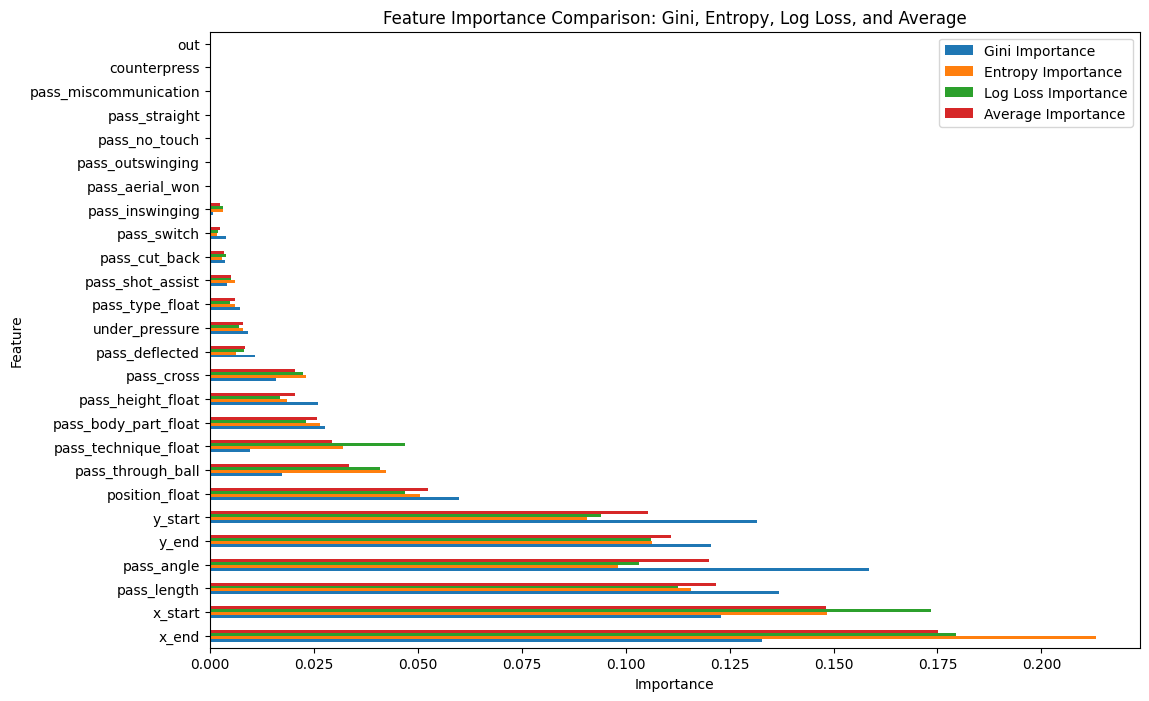

In [35]:
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gini Importance': importances_gini,
    'Entropy Importance': importances_entropy,
    'Log Loss Importance': importances_log_loss
})

# Calculate the average importance across the three criteria
importance_df['Average Importance'] = importance_df[['Gini Importance', 'Entropy Importance', 'Log Loss Importance']].mean(axis=1)

importance_df = importance_df.sort_values('Average Importance', ascending=False)

# Plot the feature importances for all criteria and the average
plt.figure(figsize=(10, 10))
importance_df.plot(x='Feature', y=['Gini Importance', 'Entropy Importance', 'Log Loss Importance', 'Average Importance'], kind='barh', figsize=(12, 8))
plt.title('Feature Importance Comparison: Gini, Entropy, Log Loss, and Average')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [134]:
features = importance_df['Feature'][:15]



<Axes: title={'center': 'Number of shots made by Napoli players'}, xlabel='player'>

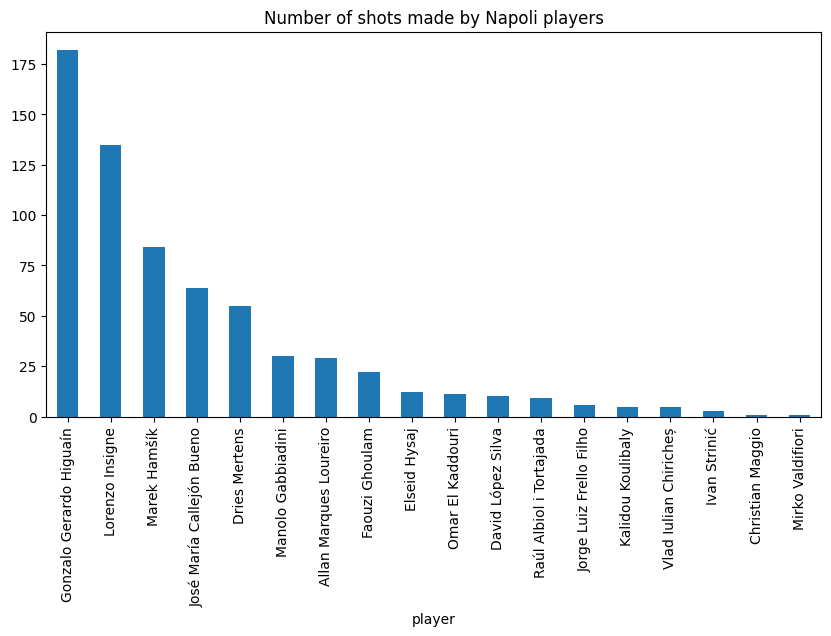

In [39]:
shots = events_napoli[events_napoli['type'] == 'Shot'].dropna(axis=1, how='all')
shots_napoli = shots[shots['team'] == 'Napoli']
plt.figure(figsize=(10, 5))
plt.title('Number of shots made by Napoli players')
shots_napoli['player'].value_counts().plot(kind='bar')

In [40]:
shots_napoli['shot_outcome'].value_counts()

shot_outcome
Off T               239
Saved               162
Blocked             147
Goal                 78
Wayward              22
Post                 11
Saved to Post         4
Saved Off Target      1
Name: count, dtype: int64

<Axes: title={'center': 'Number of goals made by Napoli players'}, xlabel='player'>

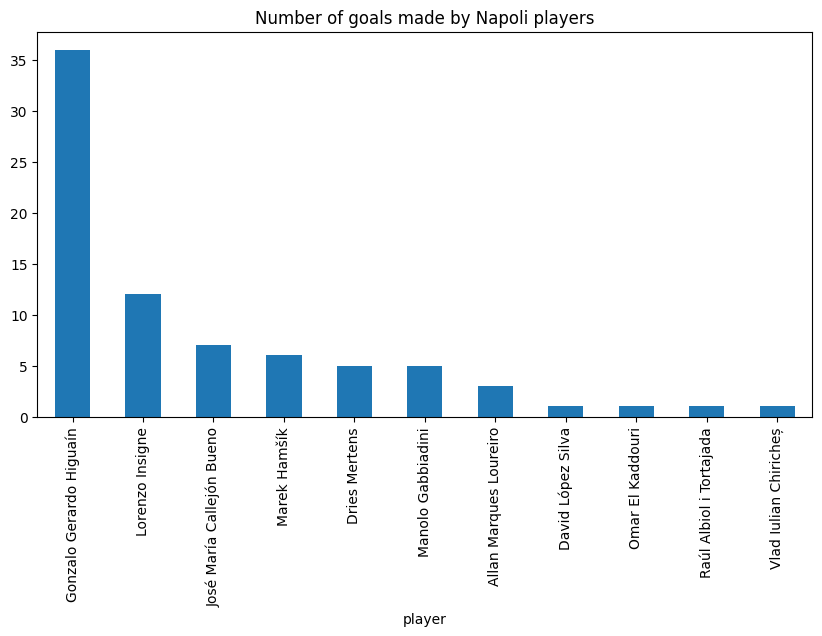

In [50]:
plt.figure(figsize=(10, 5))
plt.title('Number of goals made by Napoli players')
shots_napoli[shots_napoli['shot_outcome'] == 'Goal'].groupby('player')['shot_outcome'].count().sort_values(ascending=False).plot(kind='bar')

In [55]:
# Filter the shots dataframe for Napoli players
shots_napoli = shots[shots['team'] == 'Napoli']

# Calculate the number of goals for each player
goals_by_player = shots_napoli[shots_napoli['shot_outcome'] == 'Goal']['player'].value_counts()

# Calculate the total number of shots for each player
shots_by_player = shots_napoli['player'].value_counts()

# Calculate the conversion rate for each player
conversion_rate = goals_by_player / shots_by_player

# Find the player with the highest conversion rate
print("Player with the highest conversion rate:")
conversion_rate.sort_values(ascending=False).dropna()

Player with the highest conversion rate:


player
Vlad Iulian Chiricheș        0.200000
Gonzalo Gerardo Higuaín      0.197802
Manolo Gabbiadini            0.166667
Raúl Albiol i Tortajada      0.111111
José María Callejón Bueno    0.109375
Allan Marques Loureiro       0.103448
David López Silva            0.100000
Dries Mertens                0.090909
Omar El Kaddouri             0.090909
Lorenzo Insigne              0.088889
Marek Hamšík                 0.071429
Name: count, dtype: float64